In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import indepth_functions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

In [2]:
df = pd.read_csv('../data/interim/census/household_shopping_concat.csv')

In [3]:
df_summary = pd.read_csv('../data/processed/shopping_statistics_msa.csv')

In [4]:
df['GENERATION'] = df.TBIRTH_YEAR.apply(indepth_functions.generation_)

In [5]:
df_summary.rename({'CHNGHOW4': 'RFID-NFC', 
                   'CHNGHOW5': 'CASH', 
                   'CHNGHOW6': 'AVOID RESTR',
                   'CHNGHOW7': 'RESUME RESTR'}, axis=1, inplace=True)

In [6]:
EST_MSA = 33100
name_location = 'Miami-Fort Lauderdale-Pompano Beach'

In [7]:
df = df[df.EST_MSA == EST_MSA]

In [8]:
df1 = df.loc[:, ['CHNGHOW1', 'CHNGHOW2', 'CHNGHOW3', 'CHNGHOW4', 
                'CHNGHOW5', 'CHNGHOW6', 'CHNGHOW7']]

In [9]:
df1.rename({'CHNGHOW1': 'ONLINE',
           'CHNGHOW2': 'PICK-UP',
           'CHNGHOW3': 'IN-STORE',
           'CHNGHOW4': 'RFID-NFC', 
           'CHNGHOW5': 'CASH', 
           'CHNGHOW6': 'AVOID RESTR',
           'CHNGHOW7': 'RESUME RESTR'}, axis=1, inplace=True)

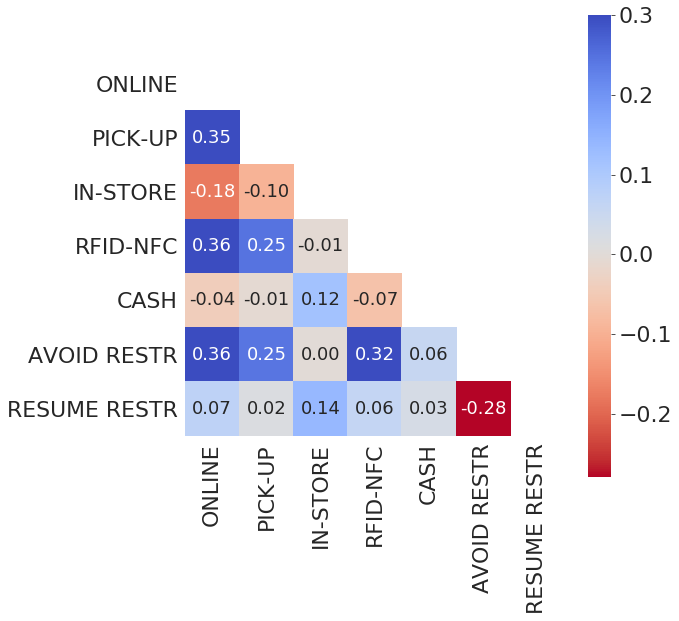

In [11]:
corr = df1.replace({np.nan: 0}).corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8.5, 8.5))
    ax = sns.heatmap(corr, 
                     mask=mask, 
                     vmax=.3, 
                     square=True, 
                     cmap="coolwarm_r", 
                     annot=True, 
                     fmt='1.2f',
                     annot_kws={"size": 18})
_ = plt.rcParams.update({'font.size': 22})

#### Avoid eating at restaurants

In [11]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramers_matrix(df, location,name_location, shopping_variable, name_variable):
    corr = []
    demographics = ['EGENDER', 'RHISPANIC', 
                    'RRACE', 'GENERATION',
                    'EEDUC', 'MS', 'THHLD_NUMPER', 
                    'THHLD_NUMKID', 'THHLD_NUMADLT']
    
    df = df[df.EST_MSA == location].loc[:, [shopping_variable] + demographics].replace({np.nan: 0})
    df.rename({shopping_variable: name_variable}, axis=1, inplace=True)

    for var in demographics:
        c = cramers_v(df[name_variable], df[var])
        corr.append(c)
    a = pd.DataFrame(corr, index=demographics)
    a = a.rename(columns={0:name_variable})
    a['ABS_CHNGHOW'] = abs(a[name_variable]) 
    varsx = list(a['ABS_CHNGHOW'][1:].sort_values(ascending=False)[:3].index)

    print('Variables more correlated to '+name_variable+': \n{}'.format(a.loc[varsx, :][name_variable]))

    a.drop(columns=['ABS_CHNGHOW'], inplace=True)
    mask = np.zeros_like(a)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(10, 10))
        ax = sns.heatmap(a, square=True, cmap="coolwarm_r", annot=True, fmt='1.2f', annot_kws={"size": 18})
       # _ = plt.title('DEMOGRAPHICS AND '+name_variable, size=16)
        _ = plt.rcParams.update({'font.size': 22})

Variables more correlated to AVOID RESTR: 
EEDUC    0.087699
MS       0.060135
RRACE    0.024795
Name: AVOID RESTR, dtype: float64


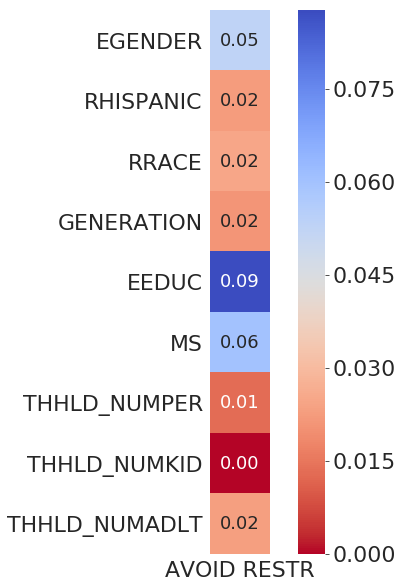

In [12]:
shopping_variable = 'CHNGHOW6'
name_variable = 'AVOID RESTR'
cramers_matrix(df, EST_MSA, name_location, shopping_variable, name_variable)

Variables more correlated to CASH: 
EEDUC            0.050279
RRACE            0.049026
THHLD_NUMADLT    0.033330
Name: CASH, dtype: float64


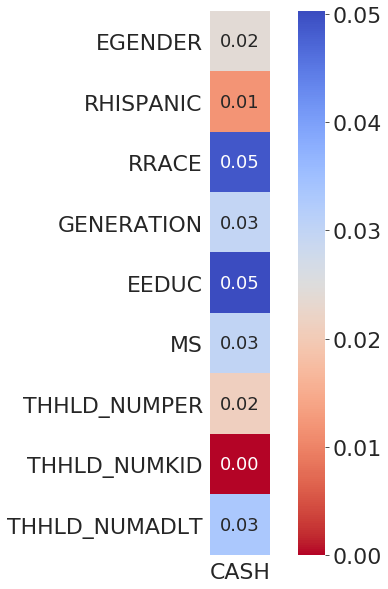

In [13]:
shopping_variable = 'CHNGHOW5'
name_variable = 'CASH'
cramers_matrix(df, EST_MSA, name_location, shopping_variable, name_variable)

Variables more correlated to ONLINE: 
EEDUC            0.186858
MS               0.096395
THHLD_NUMADLT    0.076833
Name: ONLINE, dtype: float64


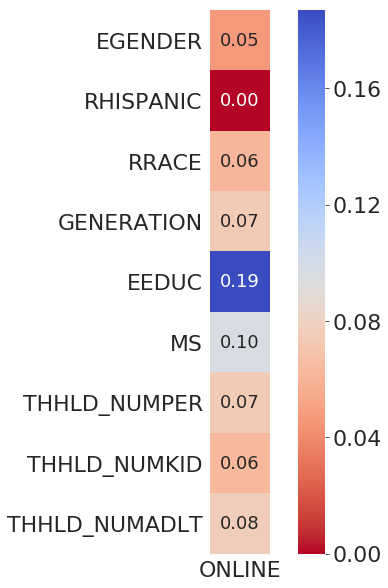

In [14]:
shopping_variable = 'CHNGHOW1'
name_variable = 'ONLINE'
cramers_matrix(df, EST_MSA, name_location, shopping_variable, name_variable)

Variables more correlated to IN-STORE: 
EEDUC         0.064229
RRACE         0.052563
GENERATION    0.033603
Name: IN-STORE, dtype: float64


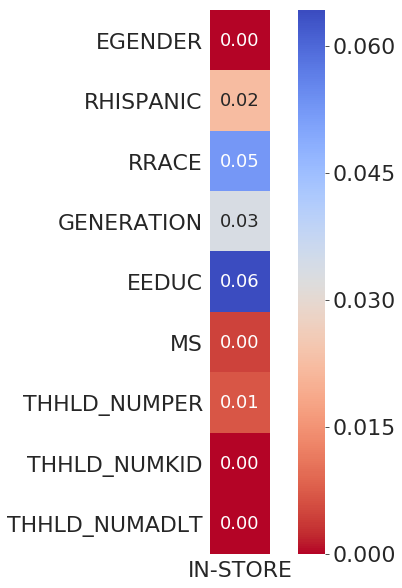

In [15]:
shopping_variable = 'CHNGHOW3'
name_variable = 'IN-STORE'
cramers_matrix(df, EST_MSA, name_location, shopping_variable, name_variable)

Variables more correlated to RESUME RESTR: 
RRACE         0.072686
EEDUC         0.061932
GENERATION    0.054060
Name: RESUME RESTR, dtype: float64


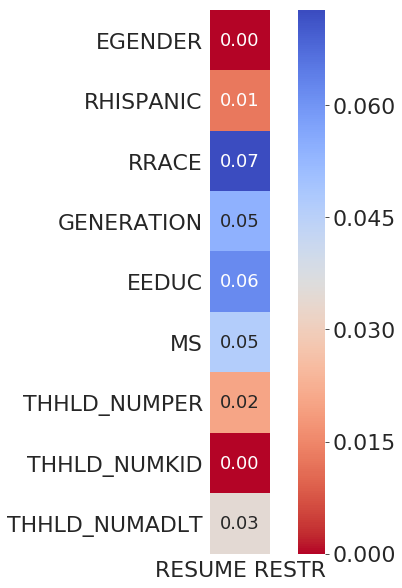

In [16]:
shopping_variable = 'CHNGHOW7'
name_variable = 'RESUME RESTR'
cramers_matrix(df, EST_MSA, name_location, shopping_variable, name_variable)

Variables more correlated to PICK-UP: 
GENERATION      0.136034
THHLD_NUMPER    0.111926
EEDUC           0.097224
Name: PICK-UP, dtype: float64


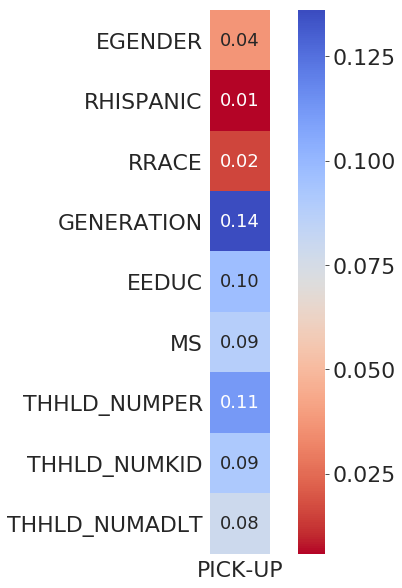

In [17]:
shopping_variable = 'CHNGHOW2'
name_variable = 'PICK-UP'
cramers_matrix(df, EST_MSA, name_location, shopping_variable, name_variable)

Variables more correlated to RFID-NFC: 
EEDUC           0.086772
THHLD_NUMPER    0.064534
GENERATION      0.057649
Name: RFID-NFC, dtype: float64


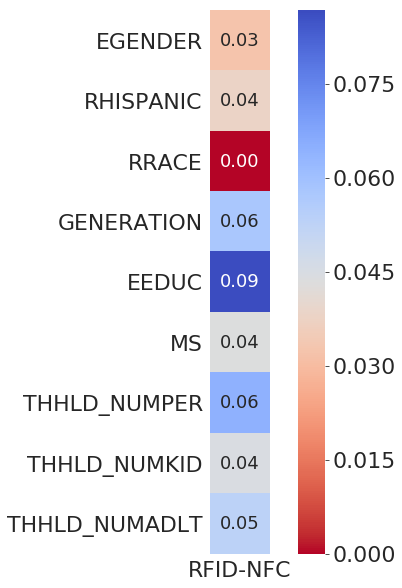

In [18]:
shopping_variable = 'CHNGHOW4'
name_variable = 'RFID-NFC'
cramers_matrix(df, EST_MSA, name_location, shopping_variable, name_variable)

## Section 2: Mobility Trends

In [19]:
df_descartes_counties = pd.read_csv('../data/interim/mobility/m50_max_counties.csv')
df_descartes_counties_percent = pd.read_csv('../data/interim/mobility/m50_percent_counties.csv')

In [20]:
df_apple = pd.read_csv('../data/interim/mobility/apple_mobility_cities.csv', index_col=0)

In [21]:
df_foursquare_dma = pd.read_csv('../data/interim/mobility/foursquare_dma.csv', index_col=0)
df_google = pd.read_csv('../data/interim/mobility/google_counties.csv', index_col=0)

In [22]:
def indexed_mobility_average_person(df, location):
    df_index = df[df.NAME == location].loc[:, '2020-03-01':]

    df_index = pd.melt(df_index, var_name='date', value_name='index')
    df_index['date'] = pd.to_datetime(df_index['date'])
    df_index['city'] = location
    
#     f, ax = plt.subplots(figsize=(15.5, 4.5))
#     _ = plt.rcParams.update({'font.size': 22})
#     _ = sns.lineplot(data=df_index, x='date', y='index')
#     _ = plt.axhline(y=100, color='k', linestyle='--', label='Baseline', lw=0.5)
#     _ = plt.xlabel('Date')
#     _ = plt.ylabel('Indexed mobility')
#     _ = plt.title('Indexed mobility for a regular person \n'+location) 
    
    return df_index

def mobility_average_person(df, location):
    df_kms= df[df.NAME == location].loc[:, '2020-03-01':]

    df_kms = pd.melt(df_kms, var_name='date', value_name='kms')
    df_kms['date'] = pd.to_datetime(df_kms['date'])
    df_kms['city'] = location
    
#     f, ax = plt.subplots(figsize=(15.5, 4.5))
#     _ = plt.rcParams.update({'font.size': 22})
#     _ = sns.lineplot(data=df_kms, x='date', y='kms')
#     _ = plt.xlabel('Date')
#     _ = plt.ylabel('Kms')
#     _ = plt.title('Mobility for a regular person \n'+location)   
    
    return df_kms

In [23]:
location = 'Miami-Dade County'

In [24]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


def serie_decomposition(df, colname, model, display, location):

    df = df[df.city == location]
    df.date = pd.to_datetime(df.date)
    df.set_index('date', inplace=True)

    if df[colname].isnull().any():
        df.fillna(method='ffill', inplace=True)
    result_add = seasonal_decompose(df[colname], model=model, extrapolate_trend='freq')
    df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
    df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
        
    return df_reconstructed

def compile_decomposition(df, variable_decomposition, location):
# Display a plot with the selected variable decomposition for driving, walking and transit
    out1 = serie_decomposition(df, 'trn', 'additive', False, location)

    out2 = serie_decomposition(df, 'drv', 'additive', False, location)

    out3 = serie_decomposition(df, 'wlk', 'additive', False, location)

    _ = plt.figure(figsize=(15.5, 4.5))

    if variable_decomposition == 'trend':
        _ = plt.plot(out1.trend, label='Transit routes')
        _ = plt.plot(out2.trend, label='Driving routes')
        _ = plt.plot(out3.trend, label='Walking routes')
    elif variable_decomposition == 'residual':
        _ = plt.plot(out1.resid, label='Transit routes')
        _ = plt.plot(out2.resid, label='Driving routes')
        _ = plt.plot(out3.resid, label='Walking routes')
    else:
        _ = plt.plot(out1.seas, label='Transit routes')
        _ = plt.plot(out2.seas, label='Driving routes')
        _ = plt.plot(out3.seas, label='Walking routes')

In [25]:
def mobility_venues_foursquare(df, location):
    df = df[[location,'class']]
    df.index = pd.to_datetime(df.index)
    
    temp = df.groupby('class').count().reset_index()
    max_data = max(temp[location])
    #only display historical data with 80% of the longer serie
    valid_venues = list(temp[temp[location] >= 0.8*max_data]['class'])
    

    return df[df['class'].isin(valid_venues)]

def mobility_venues_google(df, location):
    df = df[df.NAME == location]
    df1 = pd.melt(df, id_vars=['NAME', 'category'], var_name='Date')
    df1.Date = pd.to_datetime(df1.Date)
    temp = df1.groupby('category').count().reset_index()

    max_data = max(temp['value'])
    #only display historical data with 80% of the longer serie
    valid_venues = list(temp[temp['value'] >= 0.8*max_data]['category'])

    return df1[df1['category'].isin(valid_venues)]

In [26]:
df_index = indexed_mobility_average_person(df_descartes_counties, location)
df_kms = mobility_average_person(df_descartes_counties_percent, location)

In [27]:
location = 'Miami'
out1 = serie_decomposition(df_apple, 'trn', 'additive', False, location)
out2 = serie_decomposition(df_apple, 'drv', 'additive', False, location)
out3 = serie_decomposition(df_apple, 'wlk', 'additive', False, location)

In [28]:
df_mobility_venues_google = mobility_venues_google(df_google, 'Miami-Dade County')

In [29]:
df_index.head()

,date,index,city
0,2020-03-01,68.0,Miami-Dade County
1,2020-03-02,99.0,Miami-Dade County
2,2020-03-03,98.0,Miami-Dade County
3,2020-03-04,99.0,Miami-Dade County
4,2020-03-05,104.0,Miami-Dade County


In [30]:
df_index['location'] = 'Miami'
df_index['src'] = 'indexed regular member'
df_index['value'] = df_index['index']
df_kms['location'] = 'Miami'
df_kms['src'] = 'mobility regular member'
df_kms['value'] = df_kms['kms']

In [31]:
df_index.head()

,date,index,city,location,src,value
0,2020-03-01,68.0,Miami-Dade County,Miami,indexed regular member,68.0
1,2020-03-02,99.0,Miami-Dade County,Miami,indexed regular member,99.0
2,2020-03-03,98.0,Miami-Dade County,Miami,indexed regular member,98.0
3,2020-03-04,99.0,Miami-Dade County,Miami,indexed regular member,99.0
4,2020-03-05,104.0,Miami-Dade County,Miami,indexed regular member,104.0


In [32]:
df_mobility_venues_google = df_mobility_venues_google.reset_index().rename({'Date':'date', 'category': 'class'}, axis=1)
df_mobility_venues_google['location'] = 'Miami'
df_mobility_venues_google['source'] = 'venues google'
df_mobility_venues_google['value'] = df_mobility_venues_google['value']

In [33]:
out1 = out1.reset_index()
out1['src'] = 'transit'
out1['location'] = 'Miami'
out1['value'] = out1['actual_values']

out2 = out2.reset_index()
out2['src'] = 'driving'
out2['location'] = 'Miami'
out2['value'] = out2['actual_values']

out3 = out3.reset_index()
out3['src'] = 'walking'
out3['location'] = 'Miami'
out3['value'] = out3['actual_values']

In [34]:
df1 = df_index.loc[:, ['date', 'location', 'src', 'value']]
df2 = df_kms.loc[:, ['date', 'location', 'src', 'value']]
df3 = out1.loc[:, ['date', 'location', 'src', 'value']]
df4 = out2.loc[:, ['date', 'location', 'src', 'value']]
df5 = out3.loc[:, ['date', 'location', 'src', 'value']]

df7 = df_mobility_venues_google.loc[:, ['date', 'location', 'source', 'value', 'class']]

In [35]:
df_compilation1 = pd.concat([df1, df2, df3, df4, df5])

In [36]:
df_compilation1.head()

,date,location,src,value
0,2020-03-01,Miami,indexed regular member,68.0
1,2020-03-02,Miami,indexed regular member,99.0
2,2020-03-03,Miami,indexed regular member,98.0
3,2020-03-04,Miami,indexed regular member,99.0
4,2020-03-05,Miami,indexed regular member,104.0


In [37]:
df_compilation1.to_csv('../data/processed/mobility_compilation_miami_index.csv', index=False)

In [38]:
df_compilation2 = df7
df_compilation2.to_csv('../data/processed/mobility_compilation_miami_venues.csv', index=False)

## Section 3: Restaurants

The following analysis includes 50 businesses/every zip code of San Francisco county. The information of the restaurants was extracted using FUSION API Yelp, which allows a maximum of 50 results for endpoint using the zip codes as keywords and words as Restaurant.

In [40]:
df_restaurants = pd.read_csv('../data/interim/restaurants/yelp_sf.csv')

In [41]:
df_restaurants.head()

,ids,names,rating,review_count,price,transactions,is_closed,type_food,type_food_alias,latitude,longitude,country,state,city,zip_code
0,vmZ-bgnM5B76NUpegAjy1g,Hotbird,4.5,131,NaN,NaN,False,"Sandwiches, Chicken Shop, Burgers","sandwiches, chickenshop, burgers",37.776800,-122.416264,US,CA,San Francisco,94103.0
1,pgjbSwK_8DH2o_zQsr3dRQ,AshYan's Lu Ruo Fan,5.0,4,NaN,NaN,False,"Taiwanese, Food Delivery Services","taiwanese, fooddeliveryservices",37.777130,-122.419640,US,CA,San Francisco,NaN
2,KA-P3d2NcbJy5SQN-vCzPA,Aria Korean Street Food,4.0,891,$$,"['pickup', 'delivery']",False,"Korean, Tapas/Small Plates, Chicken Shop","korean, tapasmallplates, chickenshop",37.786550,-122.417950,US,CA,San Francisco,94109.0
3,kFgjHGp-cTUK5uPaSJOORA,Souvla,4.0,1418,$$,['delivery'],False,"Greek, Mediterranean","greek, mediterranean",37.776430,-122.425000,US,CA,San Francisco,94102.0
4,sk2OH92GwQjFKbguoFWHSw,Uncle Tito,4.0,1,NaN,NaN,False,Filipino,filipino,37.776902,-122.415244,US,CA,San Francisco,94103.0


In [42]:
df_restaurants['purchase'] = df_restaurants['transactions'].apply(indepth_functions.transaction_cleaning)

In [43]:
df_restaurants['pickup_delivery'] = df_restaurants['purchase'].apply(indepth_functions.check_pickup_delivery)

In [44]:
df_restaurants.head()

,ids,names,rating,review_count,price,transactions,is_closed,type_food,type_food_alias,latitude,longitude,country,state,city,zip_code,purchase,pickup_delivery
0,vmZ-bgnM5B76NUpegAjy1g,Hotbird,4.5,131,NaN,NaN,False,"Sandwiches, Chicken Shop, Burgers","sandwiches, chickenshop, burgers",37.776800,-122.416264,US,CA,San Francisco,94103.0,NaN,NaN
1,pgjbSwK_8DH2o_zQsr3dRQ,AshYan's Lu Ruo Fan,5.0,4,NaN,NaN,False,"Taiwanese, Food Delivery Services","taiwanese, fooddeliveryservices",37.777130,-122.419640,US,CA,San Francisco,NaN,NaN,NaN
2,KA-P3d2NcbJy5SQN-vCzPA,Aria Korean Street Food,4.0,891,$$,"['pickup', 'delivery']",False,"Korean, Tapas/Small Plates, Chicken Shop","korean, tapasmallplates, chickenshop",37.786550,-122.417950,US,CA,San Francisco,94109.0,"[pickup, delivery]",pickup and delivery
3,kFgjHGp-cTUK5uPaSJOORA,Souvla,4.0,1418,$$,['delivery'],False,"Greek, Mediterranean","greek, mediterranean",37.776430,-122.425000,US,CA,San Francisco,94102.0,[delivery],only delivery
4,sk2OH92GwQjFKbguoFWHSw,Uncle Tito,4.0,1,NaN,NaN,False,Filipino,filipino,37.776902,-122.415244,US,CA,San Francisco,94103.0,NaN,NaN


In [47]:
df_restaurants.type_food.unique()

array(['Sandwiches, Chicken Shop, Burgers',
       'Taiwanese, Food Delivery Services',
       'Korean, Tapas/Small Plates, Chicken Shop', 'Greek, Mediterranean',
       'Filipino', 'Gastropubs', 'Dim Sum, Noodles, Asian Fusion',
       'Breakfast & Brunch, Southern, Cajun/Creole',
       'Chicken Wings, Fast Food, Asian Fusion',
       'Burmese, Indonesian, Noodles',
       'Pop-Up Restaurants, Caterers, Indonesian', 'American (New)',
       'Korean', 'Mexican', 'Chinese, Vietnamese, Noodles',
       'Venezuelan, Personal Chefs, Caterers',
       'Mexican, Pop-Up Restaurants', 'Korean, Soup, Noodles', 'Pizza',
       'Vietnamese, Sandwiches', 'Thai', 'Vietnamese, Noodles, Soup',
       'Indian, Pakistani, Halal', 'Korean, Fast Food',
       'Scandinavian, Bars', 'Asian Fusion, Hawaiian, Poke',
       'Bars, American (New), Seafood',
       'American (New), Cocktail Bars, Wine Bars', 'Sushi Bars, Japanese',
       'American (Traditional)', 'Japanese', 'Vietnamese',
       'Italian, Coc

In [45]:
df_restaurants.groupby('pickup_delivery').count()

,ids,names,rating,review_count,price,transactions,is_closed,type_food,type_food_alias,latitude,longitude,country,state,city,zip_code,purchase
pickup_delivery,,,,,,,,,,,,,,,,
neither pickup nor delivery,20,20,20,20,14,20,20,20,20,20,20,20,20,20,20,20
only delivery,762,762,762,762,690,762,762,762,762,762,762,762,762,762,762,762
only pickup,57,57,57,57,55,57,57,57,57,57,57,57,57,57,57,57
pickup and delivery,979,979,979,979,735,979,979,979,979,979,979,979,979,979,979,979


In [46]:
df_restaurants.to_csv('../data/processed/yelp_SF.csv', index=False)